# BIP Framework training example 

In [20]:
using Pkg
Pkg.activate("..")
using BIPs

  Activating project at `/z1-josemm/josemm/MyDocs/personal_BIP/BIPs.jl`


In [21]:
using Statistics
using Pkg.Artifacts

Lets begin by bringing in the dataset. It contains tree splits:
* **train**: the training set with 1M jets
* **validation**: the validation set with 400k jets

And of course later we will use the **test** set with other 400k jets to report the results


In [22]:
dataset_path = "../../../DataLake/raw"
# dataset_path = "/Users/ortner/datasets/toptagging"

train_data_path = dataset_path*"/train.h5"
val_data_path = dataset_path*"/val.h5"

"../../../DataLake/raw/val.h5"

### Reading the data

In order to read the datasets, we call the `read_dataset` function:
to read the TopQuark format

In [23]:
train_jets, train_labels = BIPs.read_data("TQ", train_data_path)
train_labels = [reinterpret(Bool, b == 1.0) for b in train_labels]
print("Number of entries in the training data: ", length(train_jets))

Number of entries in the training data: 1210997

In [24]:
val_jets, val_labels = BIPs.read_data("TQ", val_data_path)
val_labels = [reinterpret(Bool, b == 1.0) for b in val_labels]
print("Number of entries in the validation data: ", length(val_jets))

Number of entries in the validation data: 402999

Lets examine how one of the jets looks like, each one of the entries is one detected particle's four momentum $(E, p_x, p_y, p_z)$.

However,in order to compute the embeddings, it is necesary to convert the jets to a format that can be used by the framework. The function `data2hyp` allows to convert each detected four momentum to the jet basis, a.k.a $(\tilde p_T, \cos(\theta), \sin(\theta), \tilde y, E_T)$

In [25]:
train_transf_jets = data2hyp(train_jets)
val_transf_jets = data2hyp(val_jets)
println("Transformed jets")

Transformed jets


### The embeddings

Once the jets are converted to the jet basis, it is moment to embed the model using the *Invariant Polynomials*. 

The function `build_ip` allocates efficiently the sparse basis, while the `bip_data` computes the invariant representation of each one of the jets.

In [26]:
f_bip, specs = build_ip(order=5, levels=7)
    
function bip_data(dataset_jets)
    storage = zeros(length(dataset_jets), length(specs))
    for i = 1:length(dataset_jets)
        storage[i, :] = f_bip(dataset_jets[i])
    end
    storage[:, 2:end]
end

bip_data (generic function with 1 method)

In [27]:
train_embedded_jets = bip_data(train_transf_jets)
println("Embedded train jets correclty")
val_embedded_jets = bip_data(val_transf_jets)
println("Embedded test jets correclty")

Embedded train jets correclty


Embedded test jets correclty


### Training a classifier model

The embeddings are now created for the dataset. From this point on, the classification itself is absolutelly versatile. For this specific example we will use the out-of-the box classifier `sklearn.linear_model.HistGradientBoostingClassifier` that bines the data and then applies a grandient boosted trees algorithm. 

Now, lets fit a simple model to the data.


In [28]:
using PyCall
@pyimport sklearn.ensemble as sk_ensemble

In [29]:
GCT = sk_ensemble.HistGradientBoostingClassifier(verbose=true, max_iter=1000, l2_regularization=0.01, ).fit(train_embedded_jets, train_labels)

1 tree, 1 leaves, max depth = 0, train loss: 0.18331, val loss: 0.18753, in 0.038s
Fit 100 trees in 44.105 s, (3010 total leaves)
Time spent computing histograms: 12.444s
Time spent finding best splits:  0.355s
Time spent applying splits:      0.550s
Time spent predicting:           0.197s
Binning 22.408 GB of training data: 79.263 s
Binning 2.490 GB of validation data: 5.633 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.62466, val loss: 0.62477, in 0.726s
[2/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.56861, val loss: 0.56872, in 0.698s
[3/1000] 1 tree, 31 leaves, max depth = 7, train loss: 0.52170, val loss: 0.52185, in 0.695s
[4/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.48191, val loss: 0.48210, in 0.647s
[5/1000] 1 tree, 31 leaves, max depth = 9, train loss: 0.44808, val loss: 0.44826, in 0.792s
[6/1000] 1 tree, 31 leaves, max depth = 8, train loss: 0.41899, val loss: 0.41922, in 0.612s
[7/1000] 1 tree, 31 leaves, 

PyObject HistGradientBoostingClassifier(l2_regularization=0.01, max_iter=1000,
                               verbose=True)

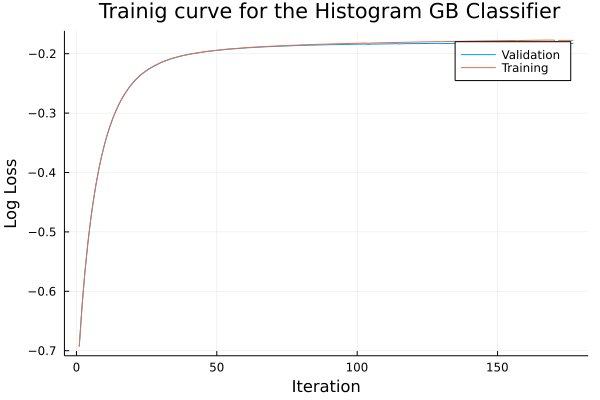

In [30]:
using Plots
Plots.plot(GCT[:validation_score_], label="Validation", xlabel="Iteration", ylabel="Log Loss")
Plots.plot!(GCT[:train_score_], label="Training", title=" Trainig curve for the Histogram GB Classifier")

# Lest test how we do performance

Now that we understanad the framework, lets see how our model performs on the test set.

In [31]:
test_data_path = "../../../DataLake/raw/test.h5"

"../../../DataLake/raw/test.h5"

In [32]:
test_jets, test_labels = BIPs.read_data("TQ", test_data_path)
test_labels = [reinterpret(Bool, b == 1.0) for b in test_labels]
test_transf_jets = data2hyp(test_jets)
test_embedded_jets = bip_data(test_transf_jets)
print("Embedded test jets correclty")

Embedded test jets correclty

In [33]:
test_preds = GCT.score(test_embedded_jets, test_labels)

0.9260019257568745

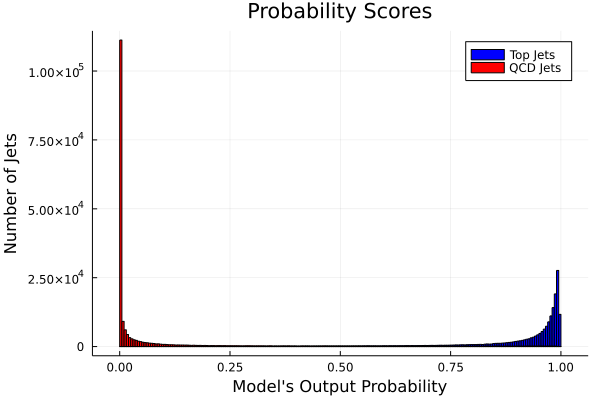

In [34]:
test_probas = GCT.predict_proba(test_embedded_jets)
bkg_index = [label==false for label in test_labels]
Plots.histogram(test_probas[:, 2][test_labels], color="Blue", label="Top Jets", xlabel="Model's Output Probability", ylabel="Number of Jets")
Plots.histogram!(test_probas[:, 2][bkg_index], color="Red", label="QCD Jets", title="Probability Scores")

In [38]:
using DelimitedFiles

In [39]:
writedlm( "foo/test_probas.csv",  test_probas, ',')
writedlm( "foo/test_labels.csv",  test_labels, ',')
